## Step 1: Fetch Place ID from Google Maps API

In [17]:
from serpapi import GoogleSearch

API_KEY = " " # SerpAPI key was used to obtain place ID can be done manually as well

params_place = {
    "engine": "google_maps",
    "q": "Papa Johns Frankfurt Niederrad", # Location search
    "api_key": API_KEY
}

search_place = GoogleSearch(params_place)
results_place = search_place.get_dict()
place_id = results_place["place_results"]["place_id"]

print("Place ID:", place_id)


Place ID: ChIJGde6-TELvUcRShvfQQ1Ymrc


## Step 2: Define Function to Fetch Reviews by Language

In [18]:
def get_all_reviews(place_id, lang_code):
    reviews = []
    next_page_token = None

    while True:
        params = {
            "engine": "google_maps_reviews",
            "place_id": place_id,
            "api_key": API_KEY,
            "hl": lang_code
        }
        if next_page_token:
            params["next_page_token"] = next_page_token

        search = GoogleSearch(params)
        result = search.get_dict()
        batch_reviews = result.get("reviews", [])
        reviews.extend(batch_reviews)

        next_page_token = result.get("serpapi_pagination", {}).get("next_page_token")
        if not next_page_token:
            break  

    return reviews

## Step 3: Fetch English and German Reviews


In [19]:
reviews_en = get_all_reviews(place_id, "en")
reviews_de = get_all_reviews(place_id, "de")

## Step 4: Combine and Deduplicate Reviews


In [20]:
all_reviews = reviews_en + reviews_de
unique_reviews = {r["review_id"]: r for r in all_reviews}
final_reviews = list(unique_reviews.values())

print(f"Total unique reviews fetched: {len(final_reviews)}")

Total unique reviews fetched: 155


## Step 5: Preview Sample Reviews


In [21]:
for review in final_reviews[:5]:
    print(f"User: {review['user']['name']}")
    print(f"Rating: {review['rating']}")
    print(f"Date: {review['date']}")
    print(f"Review snippet: {review['snippet']}")
    print("---")

User: Veggieture
Rating: 2.0
Date: vor 2 Monaten
Review snippet: Ordered a stuffed crust pizza from Papa John’s, paying 3,49 € extra for the Käserand, but the crust was empty. I requested a refund over 10 days ago and have received no response.

The pizza itself was decent. However, the breadsticks were bland.

One star taken off due to the lack of response/refund for the "unstuffed crust".
---
User: Nathan Slack
Rating: 5.0
Date: vor 2 Monaten
Review snippet: Quick and friendly service! Great place to eat if you are looking for American style pizza.
---
User: Igor Vavilin
Rating: 5.0
Date: vor einem Jahr
Review snippet: My family liked to visit Papa John‘s restaurant in the past. What a surprise we found one also in Frankfurt am Main. It is not that big, but the same time the pizza is delicious. Everything is baked while you are waiting for your order. You can even watch the process by looking at kitchen through window. The service is fast and atmosphere is friendly. Highly recommend 

## Step 6: Translate Reviews to English


In [22]:
from deep_translator import GoogleTranslator

translated_reviews = []

for review in final_reviews:
    if 'snippet' in review:
        original_text = review['snippet']
    elif 'extracted_snippet' in review and 'original' in review['extracted_snippet']:
        original_text = review['extracted_snippet']['original']
    else:
        continue

    translation = GoogleTranslator(source='auto', target='en').translate(original_text)
    translated_reviews.append({
        **review,
        'translated_snippet': translation
    })

for tr_review in translated_reviews:
    print(tr_review['translated_snippet'])


Ordered a stuffed crust pizza from Papa John’s, paying 3,49 € extra for the Käserand, but the crust was empty. I requested a refund over 10 days ago and have received no response.

The pizza itself was decent. However, the breadsticks were bland.

One star taken off due to the lack of response/refund for the "unstuffed crust".
Quick and friendly service! Great place to eat if you are looking for American style pizza.
My family liked to visit Papa John‘s restaurant in the past. What a surprise we found one also in Frankfurt am Main. It is not that big, but the same time the pizza is delicious. Everything is baked while you are waiting for your order. You can even watch the process by looking at kitchen through window. The service is fast and atmosphere is friendly. Highly recommend to everyone to visit. We usually order Super Papa and Cheesesticks - very tasty.
I recently visited this restaurant hoping for a good pizza, but was disappointed. The quality of the pizza was far below what I

In [35]:
for review in final_reviews:
    if 'snippet' in review:
        original_text = review['snippet']
    elif 'extracted_snippet' in review and 'original' in review['extracted_snippet']:
        original_text = review['extracted_snippet']['original']
    else:
        continue
    
    translation = GoogleTranslator(source='auto', target='en').translate(original_text)
    review['translated_snippet'] = translation  # add translated text to the original review object


## Step 7: Extract Negative Reviews (Rating ≤ 3)

In [36]:
negative_reviews = [r for r in final_reviews if r['rating'] <= 3]

print(f"Total negative reviews (by star rating): {len(negative_reviews)}")

# Extract review text to analyse
negative_texts = []
for review in negative_reviews:
    text = review.get('translated_snippet') or review.get('snippet') or ""
    if text:
        negative_texts.append(text)

print(f"Total negative review texts extracted: {len(negative_texts)}")


Total negative reviews (by star rating): 49
Total negative review texts extracted: 41


## Step 8: Prepare Prompt and Query Local LLM for Complaint Categorization

In [24]:
# We build a prompt asking the LLM to cluster themes & summarize complaint categories

prompt_intro = (
    "You are an AI assistant. "
    "Analyze the following customer complaint reviews. "
    "Group them into 3 main complaint categories. "
    "For each category, provide a brief label and 3 example complaints from that category.\n\n"
)

prompt_reviews = "\n\n".join(f"Review {i+1}: {text}" for i, text in enumerate(negative_texts[:50]))
# Limit reviews or adjust as needed

full_prompt = prompt_intro + prompt_reviews + "\n\nProvide the categories and examples clearly."

In [141]:
import requests

llm_api_url = " " # Insert your API URL here

# Prepare messages in chat format
messages = [
    {
        "role": "system",
        "content": "You are an AI assistant that analyzes customer reviews and groups them into complaint categories."
    },
    {
        "role": "user",
        "content": (
            "Analyze the following customer complaint reviews. "
            "Group them into 5 complaint categories"
            "For each category, provide a brief label and 3 example complaints  give descriptive statistics."
            "Also for each category give a detailed table of descriptive statistics (how many reviews in percentage, etc...)"
            "At the end provide descriptive statistics of each category (how many reviews in percentage for each category) \n\n"
            + "\n\n".join(f"Review {i+1}: {text}" for i, text in enumerate(negative_texts[:50]))
        )
    }
]

payload = {
    "model": "google/gemma-3-12b",  # Your loaded model's name or ID
    "messages": messages,
    "max_tokens": 5000, # adjust as needed
    "temperature": 0.7,
    "top_p": 0.9
}

response = requests.post(llm_api_url, json=payload)

if response.status_code == 200:
    resp_json = response.json()
    # The response will have the completion text here:
    completion_text = resp_json['choices'][0]['message']['content']
    print("\n=== LLM Generated Categories and Examples ===\n")
    print(completion_text)
else:
    print(f"Error: {response.status_code} - {response.text}")



=== LLM Generated Categories and Examples ===

Okay, here's an analysis of the customer reviews, grouped into complaint categories with descriptive statistics and a final summary table.  I've tried to be as thorough as possible.

**Complaint Categories & Analysis**

Here are the categories I've identified, along with example complaints from your provided list:

1. **Order Accuracy/Fulfillment Issues:** This covers incorrect orders, missing items, substitutions without consent, and general order failures.
2. **Food Quality (Taste/Ingredients):**  This category addresses issues related to the taste of the pizza and sides, ingredient freshness, and overall food quality.
3. **Delivery Problems:** Includes late deliveries, failed deliveries, and inaccurate delivery information.
4. **Service Issues (Staff & Communication):** This encompasses rude staff, unhelpful communication, arguments with employees, and lack of attentiveness.
5. **Pricing/Value Concerns:** Complaints about high prices, 

## Step 9: Create Dataframe from LLM Category Output

In [37]:
import pandas as pd

# Complaint category counts (adjust from LLM output)
category_data = {
    "Category": [
        "Food Quality",
        "Service Issues",
        "Delivery Problems",
        "Pricing / Value",
        "Cleanliness / Environment",
        "App / Website Issues"
    ],
    "Review_Count": [13, 9, 8, 6, 3, 1]
}

df_categories = pd.DataFrame(category_data)
df_categories["Percentage"] = (
    df_categories["Review_Count"] / df_categories["Review_Count"].sum()
) * 100

df_categories


,Category,Review_Count,Percentage
0,Food Quality,13,32.5
1,Service Issues,9,22.5
2,Delivery Problems,8,20.0
3,Pricing / Value,6,15.0
4,Cleanliness / Environment,3,7.5
5,App / Website Issues,1,2.5


## Step 10: Set Global Plot Styles


In [38]:
import matplotlib.pyplot as plt

# Global style settings 
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.grid": False,
    "xtick.color": "black",
    "ytick.color": "black",
    "font.size": 12,
    "axes.labelcolor": "black",
    "text.color": "black"
})


## Step 11: Pie Chart - Complaint Categories Percentage


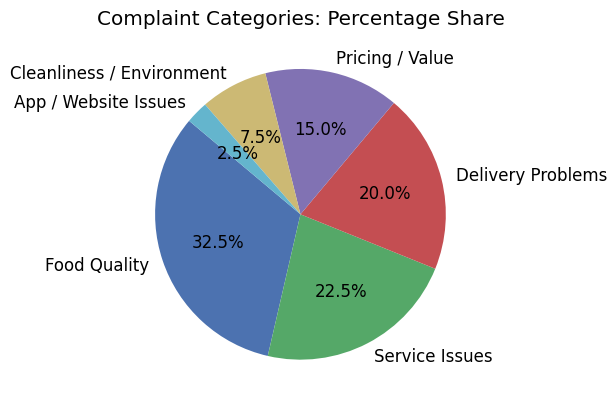

In [53]:
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B3", "#CCB974", "#64B5CD"]

plt.figure(figsize=(6, 6))
plt.pie(
    df_categories["Percentage"],
    labels=df_categories["Category"],
    autopct="%1.1f%%",
    startangle=140,
    colors=colors
)
plt.title("Complaint Categories: Percentage Share")
plt.tight_layout()
plt.show()


## Step 12: Histogram - Distribution of Negative Review Ratings

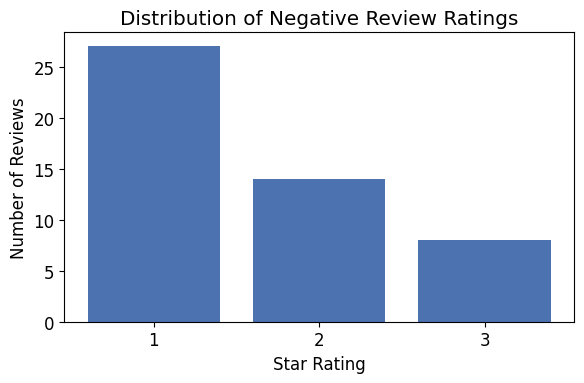

In [40]:
ratings = [r["rating"] for r in negative_reviews]

plt.figure(figsize=(6, 4))
plt.hist(ratings, bins=[1, 2, 3, 4], align="left", rwidth=0.8, color="#4C72B0")

plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Negative Review Ratings")
plt.xticks([1, 2, 3])
plt.tight_layout()
plt.show()


## Step 13: Word Cloud - Common Words in Negative Reviews 

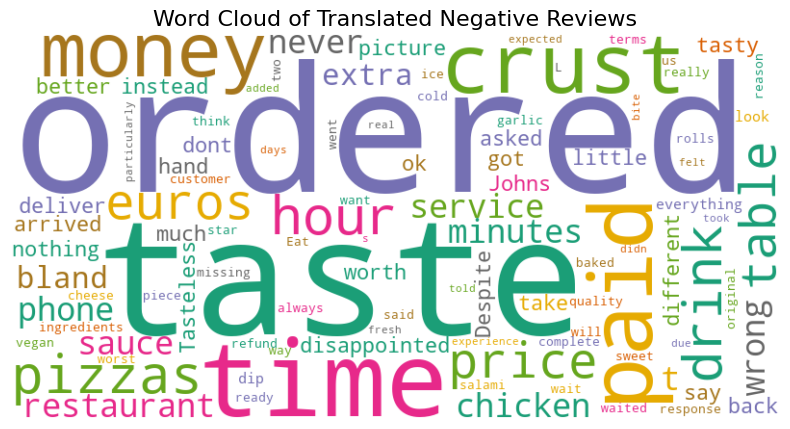

In [52]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Start with default stopwords 
stopwords = set(STOPWORDS)

# Customisable Specific stopwords (words you want to ignore)
custom_stopwords = {
                    "pizza", "order", "food", "papa", "john", "place", "delivery", "store", "also", 
                    "unfortunately", "even", "far", "received", "frankfurt", "usa", "one", "come", "good"
                    }

stopwords.update(custom_stopwords)

# Combine translated negative review texts 
translated_neg_texts = [
    review['translated_snippet']
    for review in negative_reviews
    if review.get('translated_snippet') and review['translated_snippet'].strip() != ""
]

combined_text = " ".join(translated_neg_texts)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Dark2',
    max_words=100,
    contour_width=1,
    contour_color='steelblue',
    stopwords=stopwords
).generate(combined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Translated Negative Reviews", fontsize=16)
plt.show()
